# Access Sentinel 2 Data on Planetary Computer

## Setup Instructions

This notebook is meant to run on Planetary Computer lab hub.

We need to install extra libraries first:

```bash
pip install 'odc-stac>=0.2.0a9'
```

This is enough to load data. But this notebook also uses some extra utilities
from

```bash
pip install odc-algo odc-ui
```


In [1]:
#!pip install odc-stac>=0.2.0a9
#!pip install odc-ui odc-algo

In [2]:
import numpy as np
import planetary_computer as pc
import yaml
from dask.distributed import wait as dask_wait
from IPython.display import display
from pystac_client import Client

from odc.stac import stac_load

## Configuration

For now we need to manually supply band `dtype` and `nodata` information for
each band in the collection. Use band named `*` as a wildcard.

In [3]:
cfg = """---
"*":
  warnings: ignore # Disable warnings about duplicate common names

sentinel-2-l2a:
  assets:
    '*':
      data_type: uint16
      nodata: 0
      unit: '1'
    SCL:
      data_type: uint8
      nodata: 0
      unit: '1'
    visual:
      data_type: uint8
      nodata: 0
      unit: '1'
  aliases:  # Alias -> Canonical Name
    rededge1: B05   # Work around non-unique `rededge` common name in S2
    rededge2: B06   # ..
    rededge3: B07   # ..
"""
cfg = yaml.load(cfg, Loader=yaml.CSafeLoader)

## Start Dask Client

This step is optional, but it does improve load speed significantly. You
don't have to use Dask, as you can load data directly into memory of the
notebook.

In [4]:
from datacube.utils.dask import start_local_dask

client = start_local_dask()

## Query STAC API

Here we are looking for datasets in `sentinel-2-l2a` collection from June
2019 over MGRS tile `06VVN`.

In [5]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2019-06",
    query={"s2:mgrs_tile": dict(eq="06VVN")},
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 23 datasets


## Lazy load all the bands

We won't use all the bands but it doesn't matter as bands that we won't use
won't be loaded. We are "loading" data with Dask, which means that at this
point no reads will be happening just yet.

If you were to skip `warnings: ignore` in the configuration, you'll see a
warning about `rededge` common name being used on several bands. Basically we
can only work with common names that uniquely identify some band. In this
case EO extension defines common name `rededge` for bands 5, 6 and 7.

In [6]:
SHRINK = 4
resolution = 10

if SHRINK > 1:
    resolution = resolution * SHRINK

xx = stac_load(
    items,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
    resolution=resolution,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset>
Dimensions:      (time: 23, y: 2745, x: 2745)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-01T21:15:21.024000 ... 2019-06...
  * y            (y) float64 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 32606
Data variables: (12/16)
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32606
    grid_mapping:  spatial_ref

By default `stac_load` will return all the data bands using canonical asset
names. But we can also request a subset of bands, by supplying `bands=` parameter.
When going this route you can also use "common name" to refer to a band.

In this case we request `red,green,blue,nir` bands which are common names for
bands `B04,B03,B02,B08` and `SCL` band which is a canonical name.

In [7]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir,SCL


<xarray.Dataset>
Dimensions:      (time: 23, y: 2745, x: 2745)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-01T21:15:21.024000 ... 2019-06...
  * y            (y) float64 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 32606
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32606
    grid_mapping:  spatial_ref

### Import some tools from odc.{algo,ui}

In [8]:
import ipywidgets
from datacube.utils.geometry import gbox
from odc.algo import colorize, to_float, to_rgba, xr_reproject
from odc.ui import to_jpeg_data
from odc.ui.plt_tools import scl_colormap

## Do some math with bands

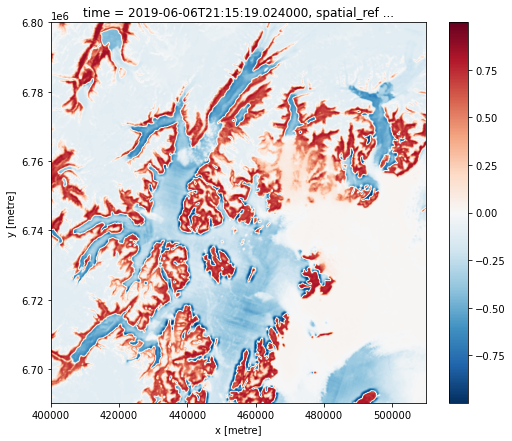

In [9]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir = to_float(xx.nir)
red = to_float(xx.red)
ndvi = (nir - red) / (
    nir + red
)  # < This is still a lazy Dask computation (no data loaded yet)

# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

For sample purposes work with first 6 observations only

In [10]:
xx = xx.isel(time=np.s_[:6])

## Generate some RGB images

In this case we take `SCL` band and "colorize" it, simply replace every known
category with an RGB pixel. Also we take RGB bands clamp pixel values into
`[0,255]` range and form an RGBA image. Alpha band is set to transparent for
those pixels that were `nodata` in the original `uint16` data for any of the
channels.

- Compute Alpha band using `.nodata` property
- Clamp band `.red,.green,.blue` to `[1, 3000]`
- Scale to `[0,255]`
- Arrange it in a 4 channel image RGBA

In our case bands were named "red,green,blue" and so `to_rgba(..)` know what
band to use for what color, if you have native band names you can use
`bands=` parameter to define which band is *red*, *green* and *blue*:

```
to_rgba(..., bands=("B04","B03","B02"))
```



In [11]:
scl_rgb = colorize(xx.SCL, scl_colormap)
im_rgba = to_rgba(xx, clamp=(1, 3_000))

## Load all the data into Dask Cluster

So far we have only constructed Dask graphs of computations we might want to
perform. Now we use `client.persist(..)` to tell Dask to actually start data
loading and processing and to keep results in the memory of the Dask cluster.
We will then pull results into local process for display as we need it.

In [12]:
%%time
scl_rgb, im_rgba = client.persist([scl_rgb, im_rgba])
_ = dask_wait([scl_rgb, im_rgba])

CPU times: user 433 ms, sys: 33.2 ms, total: 466 ms
Wall time: 3.15 s


## Plot Imagery

If all went well Dask have loaded all the data and transformed raw pixels
into RGBA images. We can now visualise results using the same `xarray` plot
tools we could use with local data. Behind the scenes Dask will transfer
imagery from the cluster to the notebook as needed, since we used
`.persist(..)` this operation should be quick. Preparing plots does take some
time, but it's mostly the cost of interpolation for display as we need to
resize ~10 megapixel images down to small size.

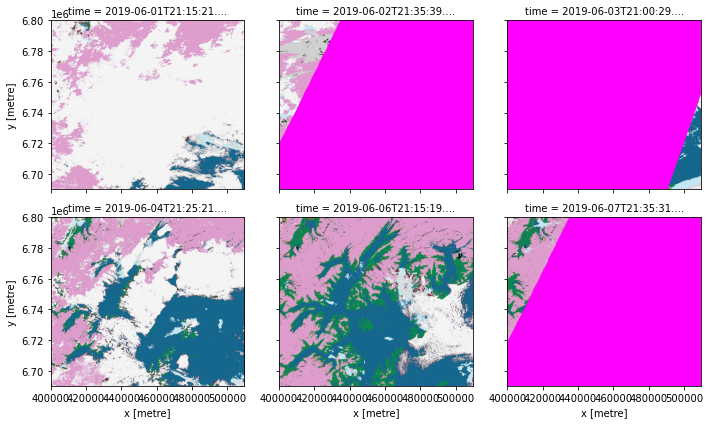

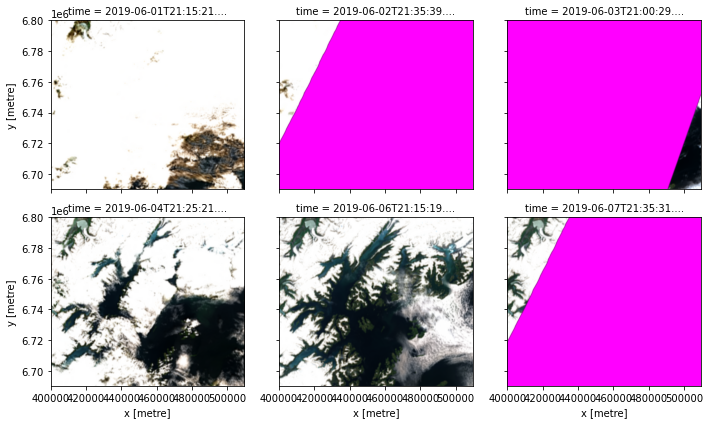

In [13]:
scl_rgb.plot.imshow(
    col="time", col_wrap=3, size=3, aspect=1, interpolation="antialiased"
)

fig = im_rgba.plot.imshow(
    col="time", col_wrap=3, size=3, aspect=1, interpolation="bicubic"
)
for ax in fig.axes.ravel():
    ax.set_facecolor("magenta")

## Make and display some thumbnails

In [14]:
# Covers same area as original but only 320x320 pixels in size
thumb_geobox = gbox.zoom_to(xx.geobox, (320, 320))

# Reproject original Data then convert to RGB
rgba_small = to_rgba(
    xr_reproject(xx[["red", "green", "blue"]], thumb_geobox, resampling="cubic"),
    clamp=(1, 3000),
)

# Same for SCL, but we can only use nearest|mode resampling
scl_small = colorize(
    xr_reproject(xx.SCL, thumb_geobox, resampling="mode"), scl_colormap
)

# Compress image 5 (index 4) to JPEG and display
idx = 4
ims = [
    ipywidgets.Image(value=to_jpeg_data(rgba_small.isel(time=idx).data.compute(), 80)),
    ipywidgets.Image(value=to_jpeg_data(scl_small.isel(time=idx).data.compute(), 80)),
]

display(ipywidgets.HBox(ims))

In [15]:
# Change to True to display higher resolution
if False:
    display(
        ipywidgets.Image(value=to_jpeg_data(im_rgba.isel(time=idx).data.compute(), 90))
    )
    display(
        ipywidgets.Image(value=to_jpeg_data(scl_rgb.isel(time=idx).data.compute(), 90))
    )

--------------------------------